In [17]:
setwd("/Users/amyheger/Desktop/STAT 577/Homework3")

library(dplyr)
library(tidyverse)
library(car)
library(glmnet) #regularization
library(leaps) #subset selection
library(class) #KNN
library(cluster) #K-means
library(rpart) #tree
library(randomForest) 
library(gbm) #boosting
library(e1071) #SVM
library(pls) #PCR & PLSR
library(nnet) #neural networks
library(IRdisplay) 

#Read in Fundraising dataset 

set.seed(12)
fund = read.csv("Fundraisingcut.csv",header=TRUE)
    #summary(fund)
    #dim(fund)
    #cor(fund) 

ERROR: Error in library(car): there is no package called 'car'


In [10]:
#log transform variables that deal with income and dollars
#fund$INCOME = log(fund$INCOME+ 1)
#fund$WEALTH = log(fund$WEALTH+ 1)
fund$Icmed = log(fund$Icmed + 1)
fund$Icavg = log(fund$Icavg + 1)
fund$HV = log(fund$HV + 1)

fund$homeowner.dummy = as.factor(fund$homeowner.dummy)
fund$gender.dummy = as.factor(fund$gender.dummy)
fund$zipconvert_2 = as.factor(fund$zipconvert_2)
fund$zipconvert_3 = as.factor(fund$zipconvert_3)
fund$zipconvert_4 = as.factor(fund$zipconvert_4)
fund$zipconvert_5 = as.factor(fund$zipconvert_5)

In [11]:
#Train model to predict who will donate funds versus not

#split data 50/50 training and test data
prop = 0.5 
xfund = as.matrix(fund[,-21])
yfund = as.factor(fund[,21])  


train_index= sample(1:nrow(xfund),prop*nrow(xfund),replace = FALSE)
test_index = c(1:nrow(xfund))[-train_index]
train_x= xfund[train_index,]
train_tarB= yfund[train_index]
  
test_x = xfund[-c(train_index),]
test_tarB = yfund[-c(train_index)]
  
train_data = data.frame(train_x, train_tarB)
test_data = data.frame(test_x, test_tarB)

In [4]:
#Logistic Regression

lr.fund = glm(factor(TARGET_B) ~ INCOME+WEALTH+Icavg+Icmed+HV+ homeowner.dummy+gender.dummy+NUMCHLD+IC15+NUMPROM+RAMNTALL+MAXRAMNT+ LASTGIFT+totalmonths+TIMELAG+AVGGIFT+zipconvert_2+zipconvert_3+zipconvert_4+zipconvert_5, data = fund[train_index,], family="binomial", maxit=50)
summary(lr.fund)

    trpred = (predict(lr.fund,type="response")) > 0.5
    lr.tr.err = mean((as.numeric(train_tarB))!=trpred)

    tspred = (predict(lr.fund,newdata=fund[test_index,-21],type="response")) > 0.5  
    lr.ts.err = mean((as.numeric(test_tarB))!=tspred)

    lr.err = c("Train.Error" = lr.tr.err, "Test.Error" = lr.ts.err)
    lr.err


Call:
glm(formula = factor(TARGET_B) ~ INCOME + WEALTH + Icavg + Icmed + 
    HV + homeowner.dummy + gender.dummy + NUMCHLD + IC15 + NUMPROM + 
    RAMNTALL + MAXRAMNT + LASTGIFT + totalmonths + TIMELAG + 
    AVGGIFT + zipconvert_2 + zipconvert_3 + zipconvert_4 + zipconvert_5, 
    family = "binomial", data = fund[train_index, ], maxit = 50)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.7808  -1.1581  -0.6608   1.1495   1.8967  

Coefficients:
                   Estimate Std. Error z value Pr(>|z|)    
(Intercept)      -1.193e+01  3.756e+02  -0.032   0.9747    
INCOME            7.051e-02  3.517e-02   2.005   0.0450 *  
WEALTH            4.379e-04  2.509e-02   0.017   0.9861    
Icavg            -4.988e-01  6.121e-01  -0.815   0.4151    
Icmed             4.764e-01  5.970e-01   0.798   0.4249    
HV                1.891e-02  1.063e-01   0.178   0.8588    
homeowner.dummy1  1.716e-01  1.328e-01   1.292   0.1963    
gender.dummy1     1.123e-01  1.066e-01   1.05

Train.Error  Test.Error 
  0.7826923   0.7820513

Logistic Regression

Totalmonths, income, and numchld are the three predictor variables that were significant. 
The training misclassification rate was 0.7827 and the test misclassification rate was almost identitcal at 0.7821.

21 x 1 sparse Matrix of class "dgCMatrix"
                           1
(Intercept)      1.161662909
homeowner.dummy  0.008106651
NUMCHLD         -0.081322922
INCOME           0.005199105
gender.dummy     .          
WEALTH           .          
HV               .          
Icmed            .          
Icavg            .          
IC15             .          
NUMPROM          0.001843564
RAMNTALL         .          
MAXRAMNT         .          
LASTGIFT         .          
totalmonths     -0.036358559
TIMELAG          .          
AVGGIFT         -0.008072931
zipconvert_2     .          
zipconvert_3     .          
zipconvert_4     .          
zipconvert_5     .          

Train.Error  Test.Error 
  0.7955128   0.7903846

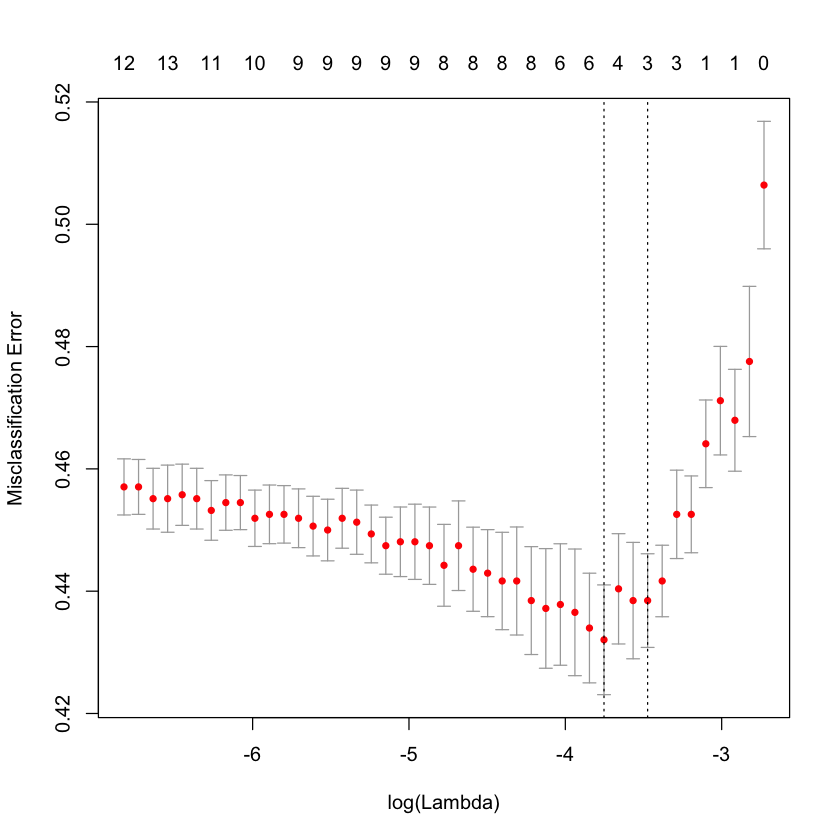

In [12]:
#Lasso Logistic Regression
train_x = data.matrix(fund[train_index,-21])
test_x = data.matrix(fund[test_index,-21])
  
la.fund = cv.glmnet(x=train_x,y=train_tarB,family="binomial",alpha=1,type.measure = "class") 
  coef(la.fund,s="lambda.min")
  #summary(la.fund)
  plot(la.fund)
  #la.fund$lambda.min
  #la.fund$lambda.1se 
  
    la.pred.train = predict(la.fund, newx = train_x, s = "lambda.min", type="class")
    la.tr.err = mean((as.numeric(train_tarB))!=la.pred.train)

    la.pred.test = predict(la.fund, newx = test_x, s = "lambda.min",type="class")
    la.ts.err = mean((as.numeric(test_tarB))!=la.pred.test)

    la.err = c("Train.Error" = la.tr.err, "Test.Error" = la.ts.err)
    la.err

Sparse Logistic Regression (Lasso)

The estimated coefficients the model maintained were the intercept, numchld, total months, homeowner.dummy, avggift, income, and numprom.
The training misclassification rate was 0.7955 and the test misclassification rate was only slightly better at 0.7904.



Classification tree:
rpart(formula = factor(TARGET_B) ~ INCOME + WEALTH + Icavg + 
    Icmed + HV + homeowner.dummy + gender.dummy + NUMCHLD + IC15 + 
    NUMPROM + RAMNTALL + MAXRAMNT + LASTGIFT + totalmonths + 
    TIMELAG + AVGGIFT + zipconvert_2 + zipconvert_3 + zipconvert_4 + 
    zipconvert_5, data = fund, subset = train_index)

Variables actually used in tree construction:
[1] AVGGIFT     LASTGIFT    NUMCHLD     NUMPROM     WEALTH      totalmonths

Root node error: 772/1560 = 0.49487

n= 1560 

        CP nsplit rel error  xerror     xstd
1 0.112694      0   1.00000 1.00000 0.025580
2 0.012090      1   0.88731 0.90026 0.025429
3 0.011658      4   0.85104 0.93264 0.025505
4 0.010363      6   0.82772 0.93005 0.025500
5 0.010000      8   0.80699 0.93523 0.025510


Train.Error  Test.Error 
     0.4096      0.4551

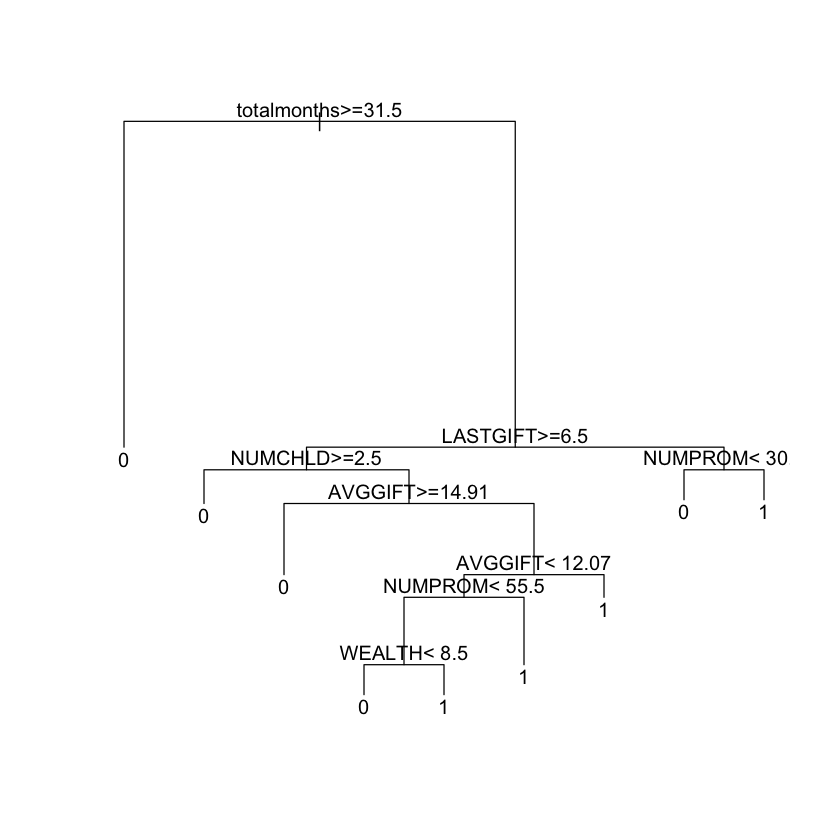

In [38]:
tree.fund= rpart(factor(TARGET_B)~ INCOME+WEALTH+Icavg+Icmed+HV+homeowner.dummy+gender.dummy+NUMCHLD+IC15+NUMPROM+RAMNTALL+MAXRAMNT+LASTGIFT+ totalmonths+TIMELAG+AVGGIFT+zipconvert_2+zipconvert_3+zipconvert_4+zipconvert_5, data=fund, subset=train_index)
    #summary(tree.fund)
    printcp(tree.fund)
    plot(tree.fund)
    text(tree.fund, pretty=0)

    prune.fund=prune.rpart(tree.fund, cp= 0.011658, best=2)     
    tree.trpred=predict(prune.fund,type="class")
    tree.tspred=predict(prune.fund,fund[test_index,-21],type="class")

    tree.trerr = round(mean(train_tarB!=tree.trpred),4)
    tree.tserr = round(mean(test_tarB!=tree.tspred),4)

    tree.err = c("Train.Error"=tree.trerr, "Test.Error" = tree.tserr)
    tree.err

Classification Tree model

The training misclassification rate was 0.4096 and the test misclassification rate was 0.4551. 
The tree performed better than sparse and logistic regression.


Call:
 randomForest(formula = factor(TARGET_B) ~ INCOME + WEALTH + Icavg +      Icmed + HV + homeowner.dummy + gender.dummy + NUMCHLD + IC15 +      NUMPROM + RAMNTALL + RAMNTALL + LASTGIFT + totalmonths +      TIMELAG + AVGGIFT + zipconvert_2 + zipconvert_3 + zipconvert_4 +      zipconvert_5, data = fund, mtry = 19, ntree = 500, importance = TRUE,      subset = train_index) 
               Type of random forest: classification
                     Number of trees: 500
No. of variables tried at each split: 19

        OOB estimate of  error rate: 47.63%
Confusion matrix:
    0   1 class.error
0 424 364   0.4619289
1 379 393   0.4909326

,0,1,MeanDecreaseAccuracy,MeanDecreaseGini
INCOME,-1.35212652,2.8932844,1.12511761,37.307761
WEALTH,-5.91060583,3.6532146,-1.86227371,24.435442
Icavg,1.56441560,1.1732631,2.55053543,67.408097
Icmed,0.90293414,2.9779447,3.75668194,69.533636
HV,-1.34584863,3.3295184,1.51705751,86.189517
homeowner.dummy,-1.27559453,-0.5079803,-1.27699846,7.135998
gender.dummy,1.39654436,-1.5083082,-0.05393777,7.932350
NUMCHLD,0.40303980,1.6278665,1.41101045,8.102845
IC15,-1.99164793,-0.3170291,-2.01920836,57.769863
NUMPROM,-0.02305143,0.6736467,0.53297341,71.669172


Train.Error  Test.Error 
     0.4763      0.4699

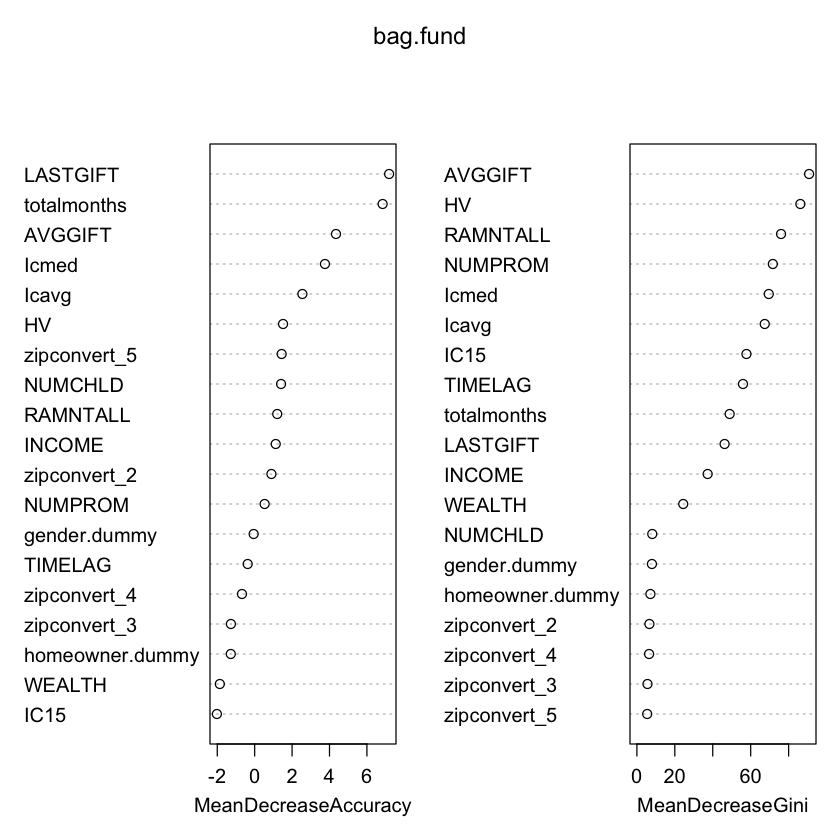

In [39]:
#Bagged Classification Trees Model
bag.fund = randomForest(factor(TARGET_B)~INCOME+WEALTH+Icavg+Icmed+HV+homeowner.dummy+gender.dummy+NUMCHLD+IC15+NUMPROM+RAMNTALL+RAMNTALL+ LASTGIFT+totalmonths+TIMELAG+AVGGIFT+ zipconvert_2+zipconvert_3+zipconvert_4+zipconvert_5, data=fund, subset=train_index, mtry=19, ntree=500,importance=TRUE)
bag.fund  
importance(bag.fund)  # variable importance measures
varImpPlot(bag.fund)  # variable importance plot

    bag.trpred=predict(bag.fund,type="class")  
    bag.tspred=predict(bag.fund,fund[test_index,-21],type="class")  

    bag.trerr = round(mean(train_tarB!=bag.trpred),4)
    bag.tserr = round(mean(test_tarB!=bag.tspred),4)

    bag.err = c("Train.Error" = bag.trerr, "Test.Error" = bag.tserr)
    bag.err

Bagged Classification Trees Model

The training misclassification rate was 0.4763 and the test misclassification rate was 0.4699. 
The bagged tree did little to improve the test misclassification rate from basic tree.


Train.Error  Test.Error 
     0.4801      0.4564

,0,1,MeanDecreaseAccuracy,MeanDecreaseGini
homeowner.dummy,-0.3224413,0.8558542,0.3472055,8.931507
NUMCHLD,1.8222568,3.3141833,3.3938490,6.874579
INCOME,0.5177940,0.6378118,0.7804894,34.175770
gender.dummy,0.1911839,-1.2155153,-0.7628448,9.891030
WEALTH,-6.0878811,2.5825457,-2.9673796,26.090262
HV,-1.1601653,1.9049642,0.6033467,73.922125
Icmed,1.5282917,3.2273064,4.4197916,69.779291
Icavg,1.7018103,1.2709494,2.9554640,69.272118
IC15,-3.6707038,1.2189741,-2.2692417,57.244269
NUMPROM,2.1162295,0.4401645,2.3500917,65.763047


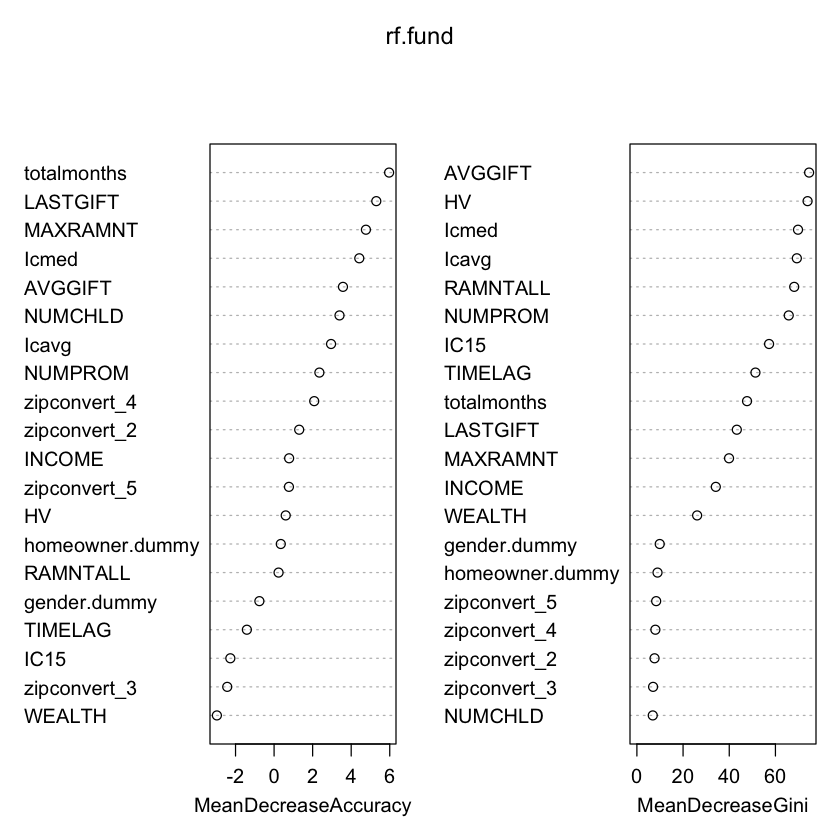

In [41]:
#Random Forests Model
rf.fund = randomForest(factor(TARGET_B)~.,data=fund,subset=train_index,mtry=sqrt(20),importance= TRUE)

    rf.trpred=predict(rf.fund,type="class")
    rf.tspred=predict(rf.fund,fund[test_index,-21],type="class")

    rf.trerr = round(mean(train_tarB!=rf.trpred),4)
    rf.tserr = round(mean(test_tarB!=rf.tspred),4)

    rf.err = c("Train.Error" = rf.trerr, "Test.Error" = rf.tserr)
    rf.err

    importance(rf.fund)
    varImpPlot(rf.fund)

Random Forests Model

The training misclassification rate was 0.4801 and the test misclassification rate was 0.4564. 
The random forest improved the test misclassification rate a little compared to the other tree methods tested so far.

,var,rel.inf
,<fct>,<dbl>
HV,HV,13.8669155
AVGGIFT,AVGGIFT,12.5436079
RAMNTALL,RAMNTALL,11.8078234
Icmed,Icmed,10.0865853
Icavg,Icavg,9.2579494
NUMPROM,NUMPROM,8.8719512
IC15,IC15,6.0754783
TIMELAG,TIMELAG,5.7220243
totalmonths,totalmonths,4.8577570


OOB generally underestimates the optimal number of iterations although predictive performance is reasonably competitive. Using cv_folds>1 when calling gbm usually results in improved predictive performance.



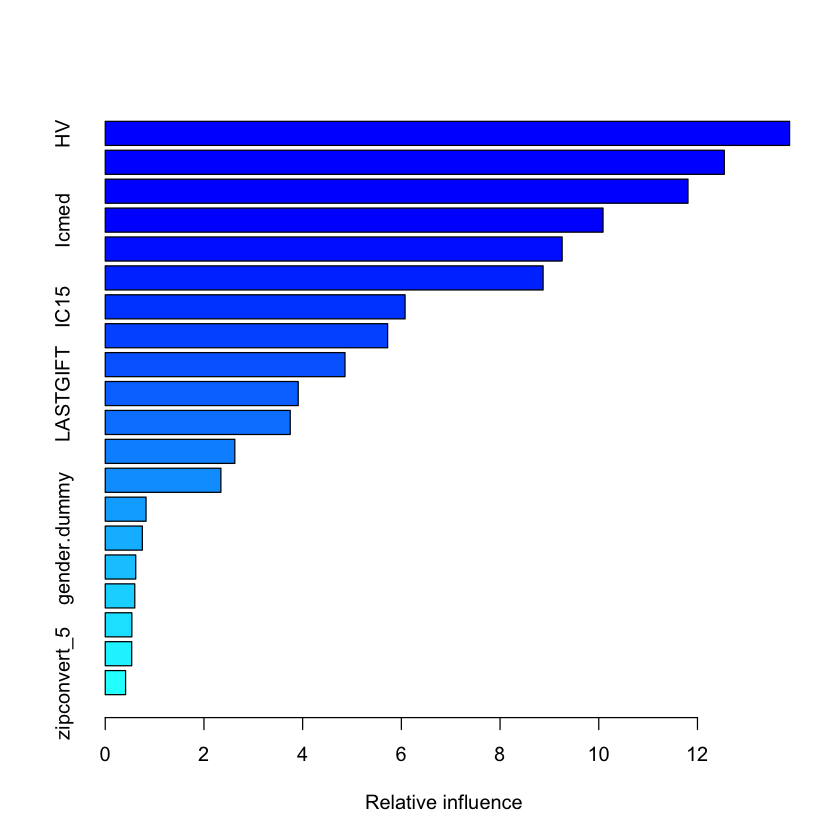

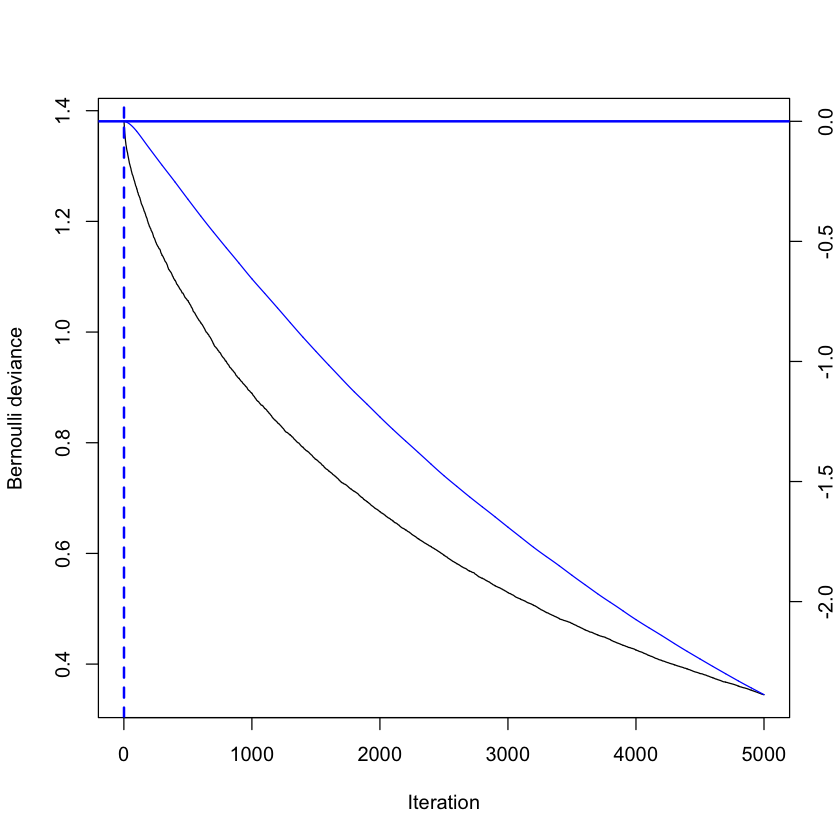

[1] 1
attr(,"smoother")
Call:
loess(formula = object$oobag.improve ~ x, enp.target = min(max(4, 
    length(x)/10), 50))

Number of Observations: 5000 
Equivalent Number of Parameters: 39.99 
Residual Standard Error: 0.0001946354

Train.Error  Test.Error 
     0.9147      0.4577

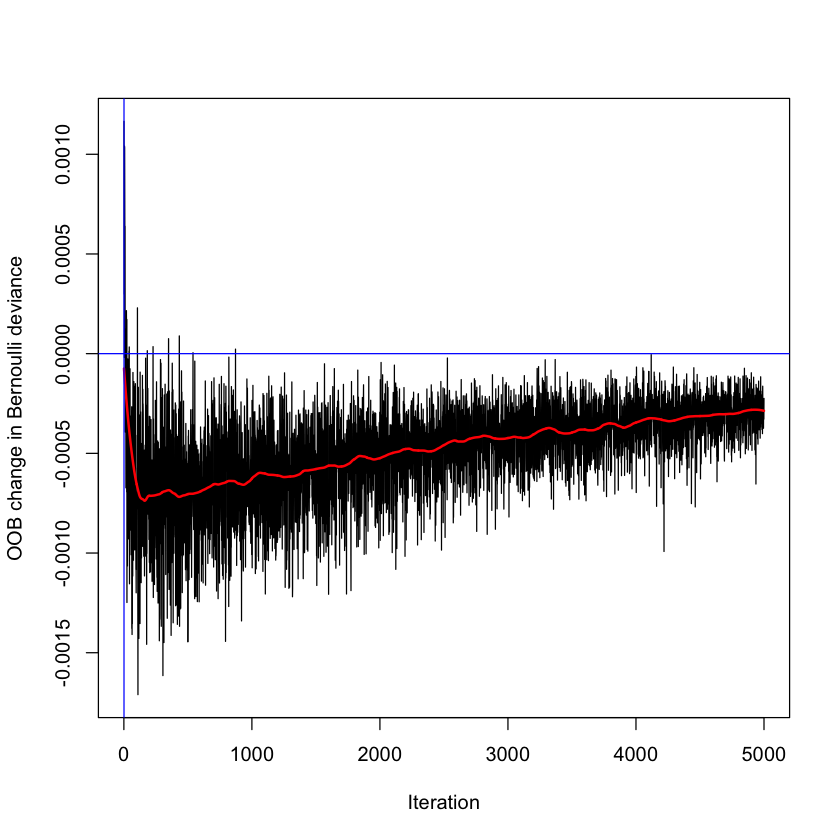

In [42]:
#Boosted Classification Tree Model

bs.fund=gbm(TARGET_B~., data=fund[train_index,], distribution="bernoulli",n.trees=5000,interaction.depth=2) #check dist and depth
summary(bs.fund)   # Gives the variable importance

#### Selecting number of trees
gbm.perf(bs.fund,
         plot.it = TRUE,
         oobag.curve = TRUE,
         overlay = TRUE,
         method="OOB")
         

bs.trpred=(predict(bs.fund,n.trees=962,type="response")) > 0.5
bs.tspred=predict(rf.fund,n.trees=962,fund[test_index,-21],type="response")

bs.trerr = round(mean((as.numeric(train_tarB))!=bs.trpred),4)
bs.tserr = round(mean(test_tarB!=bs.tspred),4)

bs.err = c("Train.Error" = bs.trerr, "Test.Error" = bs.tserr)
bs.err

Boosted Classification Tree Model

The training misclassification rate was 0.9147 and the test misclassification rate was 0.4577. Boosting has a misclassification rate similar to the random forest method.

In [44]:
#SVM with radial basis

#tune function for cross-validation
tune.out=tune(svm,factor(TARGET_B)~.,data=fund[train_index,],kernel="radial",
              ranges = list(cost=c(0.001,0.01,0.1,1,5,10,100)), gamma = c(0.1,0.5,1,2,3,4))
summary(tune.out)
bestmod = tune.out$best.model
summary(bestmod)

svm.fund=svm(factor(TARGET_B)~.,data=fund[train_index,],kernel="radial", cost =.1, scale =FALSE)
summary(svm.fund)
#plot(svm.fund,train_data)

svm.predtr = predict(svm.fund,fund[train_index,])
svm.predts = predict(bestmod,fund[test_index,-21]) # prediction using the best model

svm.errTr = round(sum(svm.predtr!=train_tarB)/length(train_tarB),4)
svm.errTs = round(sum(svm.predts!=test_tarB)/length(test_tarB),4)

svm.err = c("Train.Error" = svm.errTr, "Test.Error" = svm.errTs)
svm.err


Parameter tuning of 'svm':

- sampling method: 10-fold cross validation 

- best parameters:
 cost
  0.1

- best performance: 0.4487179 

- Detailed performance results:
   cost     error dispersion
1 1e-03 0.5089744 0.02567661
2 1e-02 0.5089744 0.02567661
3 1e-01 0.4487179 0.03282541
4 1e+00 0.4711538 0.02225712
5 5e+00 0.4865385 0.02554290
6 1e+01 0.4961538 0.03728005
7 1e+02 0.5076923 0.03375798



Call:
best.tune(method = svm, train.x = factor(TARGET_B) ~ ., data = fund[train_index, 
    ], ranges = list(cost = c(0.001, 0.01, 0.1, 1, 5, 10, 100)), 
    kernel = "radial", gamma = c(0.1, 0.5, 1, 2, 3, 4))


Parameters:
   SVM-Type:  C-classification 
 SVM-Kernel:  radial 
       cost:  0.1 

Number of Support Vectors:  1516

 ( 757 759 )


Number of Classes:  2 

Levels: 
 0 1





Call:
svm(formula = factor(TARGET_B) ~ ., data = fund[train_index, ], kernel = "radial", 
    cost = 0.1, scale = FALSE)


Parameters:
   SVM-Type:  C-classification 
 SVM-Kernel:  radial 
       cost:  0.1 

Number of Support Vectors:  1559

 ( 772 787 )


Number of Classes:  2 

Levels: 
 0 1




Train.Error  Test.Error 
     0.4949      0.4372

SVM with radial basis

The training misclassification rate was 0.4949 and the test misclassification rate was 0.4372. 
The radial support vector machine produced the best misclassification rate of all methods.

In [45]:
errmat = cbind(lr.err,la.err,bag.err,rf.err,bs.err,svm.err) #tree.err,
rownames(errmat) = c("Training","Test")
colnames(errmat) = c("Lasso","LogisticReg","Bagging","RandomForests","Boosting","SVM") #"tree", 
errmat

,Lasso,LogisticReg,Bagging,RandomForests,Boosting,SVM
Training,0.7826923,0.7955128,0.4763,0.4801,0.9147,0.4949
Test,0.7820513,0.7903846,0.4699,0.4564,0.4577,0.4372


Summary of Results:
The radial kernel SVM model produced the best test misclassification rate at 43.7% and should be the method used going forward. However, the performance deficits would be minimal if the marketers were to employ the random forest or boosting methods. 

The top three predictors the marketing team should focus on further is totalmonths, avggift, and possibly Icmed. Unfortunately, a SVM with radial kernels lacks any straightforward interpretabiliy of the importance of each predictor. Totalmonths and avggift are corroborated as important in many of the other methods tested. I selected Icmed as the third significant predictor variable based on the variable importance metrics given from the boosting and random forest models, which had test misclassification rates right behind the SVM radial method's.